In [1]:
import sys
import dataloading
import sensors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import plotly.graph_objects as go
import seaborn as sns

### load dataset1

In [2]:
df = dataloading.load_data6()

[['attitude.roll', 'attitude.pitch', 'attitude.yaw'], ['gravity.x', 'gravity.y', 'gravity.z'], ['rotationRate.x', 'rotationRate.y', 'rotationRate.z'], ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series


In [3]:
df = df.drop(columns=['subject'])
print(df.shape)
df.head()

(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,activity
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,downstairs
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,downstairs
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,downstairs
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,downstairs
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,downstairs


In [4]:
X_train,y_train,X_test,y_test,labels = dataloading.train_test_split(df,test_size=0.2)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
print(labels)

X_train: (1130292, 12), y_train: (1130292,), X_test: (282573, 12), y_test: (282573,)
['downstairs' 'jogging' 'sitting' 'standing' 'upstairs' 'walking']


In [12]:
def to_data6_df(acc_df, gravity_df, rot_rate_df, orientation_df):
    acc_df_ios_coord = acc_df.copy()
    acc_df_ios_coord = acc_df / 9.81
    acc_df_ios_coord['x'] = -acc_df_ios_coord['x']
    acc_df_ios_coord['y'] = -acc_df_ios_coord['y']
    acc_df_ios_coord['z'] = -acc_df_ios_coord['z']
    
    gravity_coord_ios_df = gravity_df.copy()
#     gravity_coord_ios_df = gravity_coord_ios_df / 9.81
#     gravity_coord_ios_df['x'] = -gravity_coord_ios_df['x']
#     gravity_coord_ios_df['y'] = -gravity_coord_ios_df['y']
#     gravity_coord_ios_df['z'] = -gravity_coord_ios_df['z']

    
    orientation_df_ios_coord = orientation_df.copy()
    orientation_df_ios_coord['roll'] = -orientation_df_ios_coord['roll']
    orientation_df_ios_coord['pitch'] = -orientation_df_ios_coord['pitch']
    orientation_df_ios_coord['yaw'] = -orientation_df_ios_coord['yaw']
    dfs = [orientation_df_ios_coord[['roll', 'pitch', 'yaw']], gravity_coord_ios_df[['x', 'y', 'z']], rot_rate_df[['x', 'y', 'z']], acc_df_ios_coord[['x', 'y', 'z']]]

    # Find the minimum number of samples
    min_samples = min(len(df) for df in dfs)

    # add an empty cosine column till we find what this thing is
    #cos_df = pd.DataFrame({'cos': [0] * min_samples})

    # Trim each DataFrame to the minimum length
    balanced_df_list = [df.iloc[:min_samples] for df in dfs] #+ [cos_df]
    balanced_df = pd.concat(balanced_df_list, axis = 1)
    
    return balanced_df

### Test Standing

In [6]:
data_path = "/Users/admin/Desktop/sensors/data/" + "standing_1"

acc_df, gravity_df, rot_rate_df, orientation_df = sensors.read_android_logger_sensor_data(data_path)
test_data_df = to_data6_df(sensors.take_df_subset(acc_df, 0.15, 0.15), sensors.take_df_subset(gravity_df, 0.15, 0.15), sensors.take_df_subset(rot_rate_df, 0.15, 0.15), sensors.take_df_subset(orientation_df, 0.15, 0.15))

label_type = 'standing'
label_index = np.where(labels == label_type)[0][0]
real_test_labels = np.full((test_data_df.shape[0]), label_index)
test_df = pd.concat([test_data_df, pd.DataFrame({'activity':real_test_labels})], axis=1).dropna()
test_df.head()

,roll,pitch,yaw,x,y,z,x,y,z,x,y,z,activity
62,1.568980,-1.484895,-3.134560,-0.082888,0.996216,0.000281,0.458862,-0.826112,-1.073120,0.000508,0.002373,-0.006655,3.0
63,1.568912,-1.484213,-3.134480,-0.084795,0.996056,-0.000498,0.170975,-0.636895,0.169111,-0.009720,0.000853,-0.002680,3.0
64,1.579826,-1.483526,3.136783,-0.086240,0.995932,-0.000447,0.519050,-1.194161,1.904558,-0.007785,-0.000123,0.001547,3.0
65,1.570885,-1.482428,-3.136624,-0.086997,0.995866,0.000124,0.134223,-0.074302,3.523759,-0.002201,0.001525,0.005462,3.0
66,1.561290,-1.481574,-3.126110,-0.087377,0.995832,0.000483,-0.535162,1.035969,2.492317,0.001440,-0.000356,0.004987,3.0


In [7]:
X_train_real, y_train_real, X_test_real, y_test_real,_ = dataloading.train_test_split(test_df,test_size=0.99, scaler_type="standard",should_map_labels=False)
print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")
client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
dataloading.save_client_data(client_data,"dataset_6_real_experiment_1")

X_train: (1, 12), y_train: (1,), X_test: (142, 12), y_test: (142,)


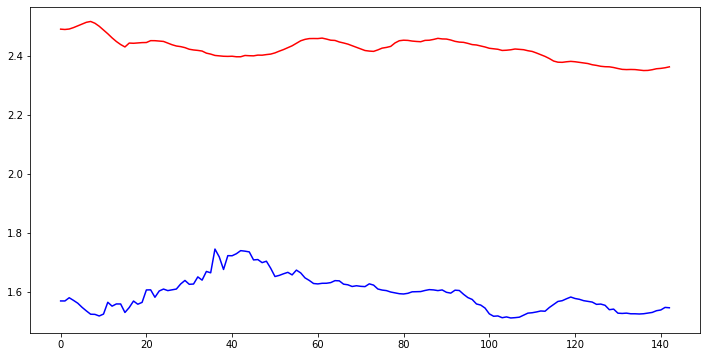

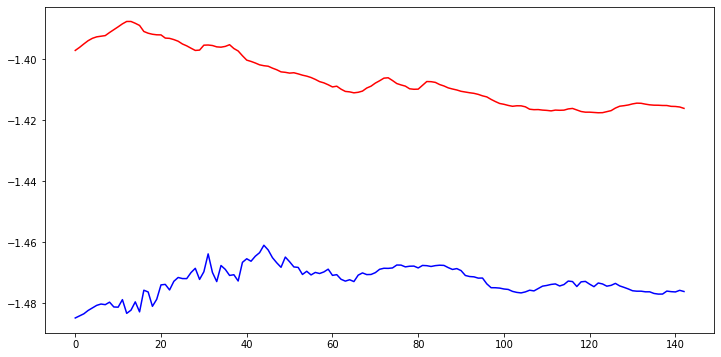

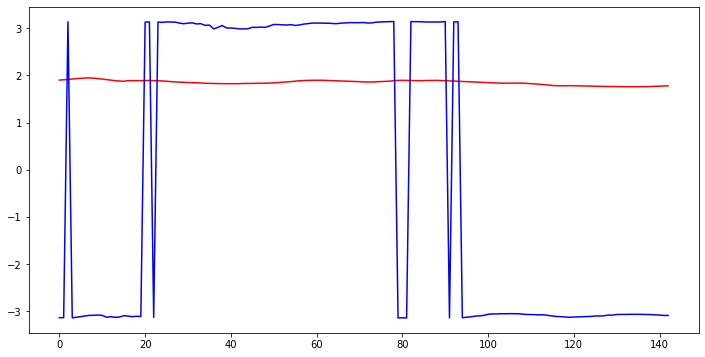

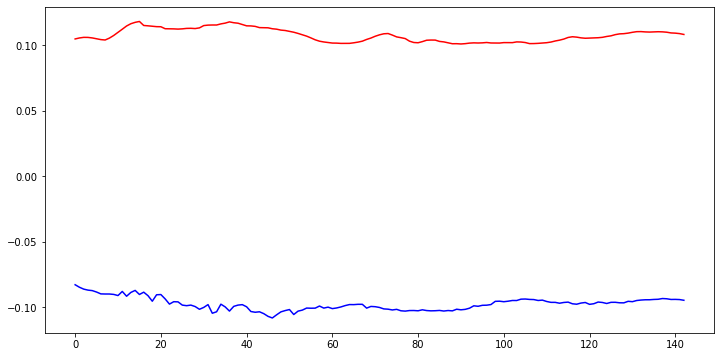

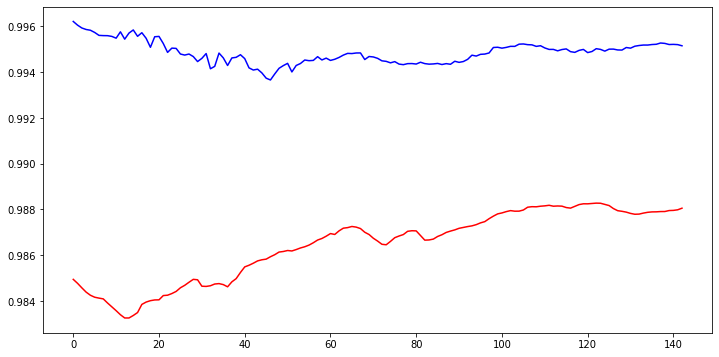

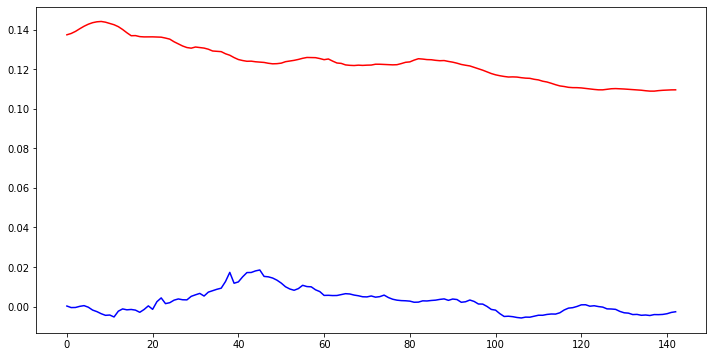

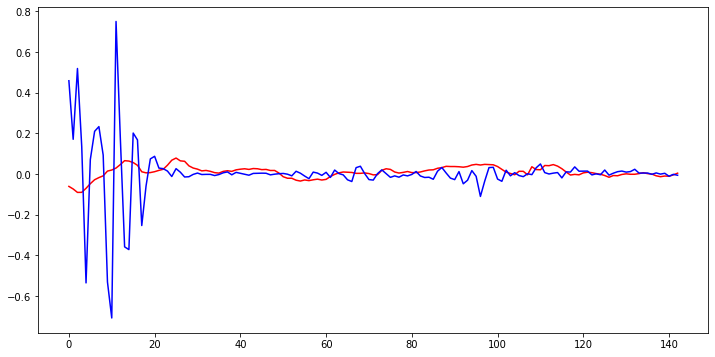

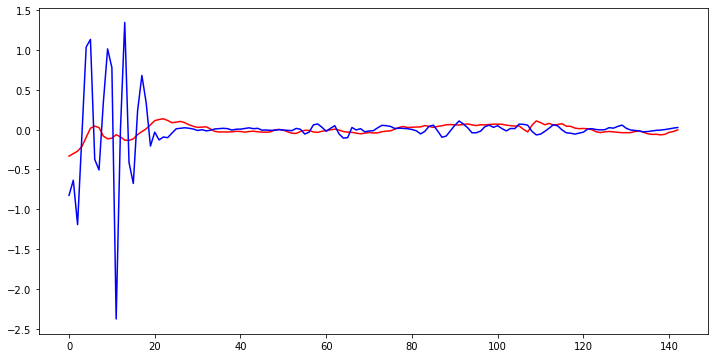

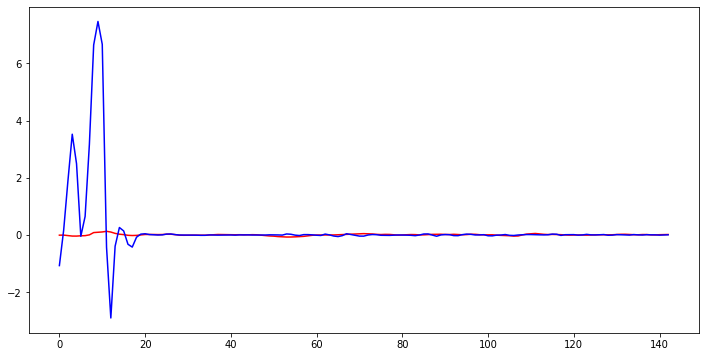

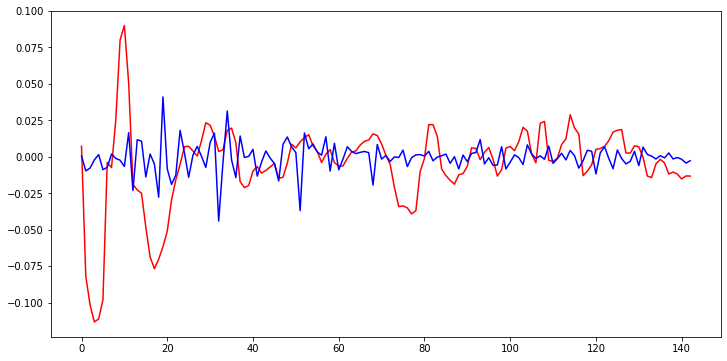

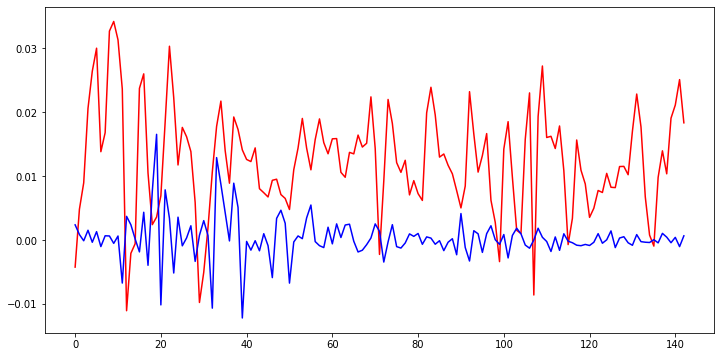

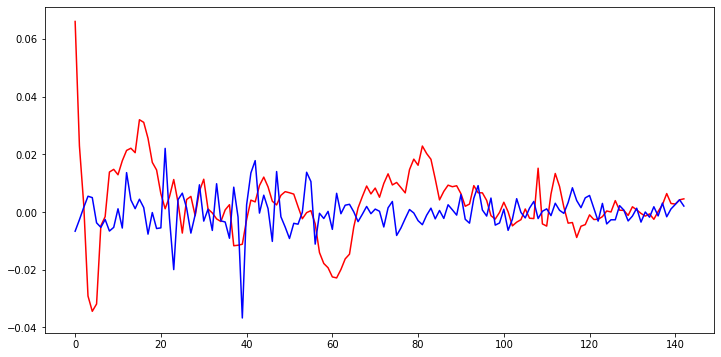

In [8]:
walking_data = df[df['activity'] == 'standing'].to_numpy()
real_data = test_df.to_numpy()


for idx in range(X_train.shape[1]):
    plt.figure(figsize=[12,6])
    plt.plot(walking_data[0:real_data.shape[0], idx], color='r')
    plt.plot(real_data[:, idx], color='b')

### Test Running

In [15]:
data_path = "/Users/admin/Desktop/sensors/data/" + "downstairs"

acc_df, gravity_df, rot_rate_df, orientation_df = sensors.read_android_logger_sensor_data(data_path)
test_data_df = to_data6_df(sensors.take_df_subset(acc_df, 0.15, 0.15), sensors.take_df_subset(gravity_df, 0.15, 0.15), sensors.take_df_subset(rot_rate_df, 0.15, 0.15), sensors.take_df_subset(orientation_df, 0.15, 0.15))

label_type = 'downstairs'
label_index = np.where(labels == label_type)[0][0]
real_test_labels = np.full((test_data_df.shape[0]), label_index)
test_df = pd.concat([test_data_df, pd.DataFrame({'activity':real_test_labels})], axis=1).dropna()
test_df.head()

,roll,pitch,yaw,x,y,z,x,y,z,x,y,z,activity
92,1.593026,-0.922655,-0.646635,0.614179,-0.783376,-0.091784,-0.015047,0.676043,-0.371244,-0.282947,0.291742,-0.087679,0.0
93,1.632266,-0.962500,-0.583625,0.603350,-0.796935,-0.013414,0.239019,-1.989779,0.297342,0.239609,-0.041438,0.053926,0.0
94,1.662088,-0.958822,-0.564304,0.570196,-0.820343,-0.035094,0.421711,-1.464338,0.512259,-0.148302,-0.240710,-0.035170,0.0
95,1.722709,-0.971536,-0.592247,0.571897,-0.818236,-0.052355,1.353684,0.520914,0.551141,-0.075450,-0.294305,-0.090748,0.0
96,1.744845,-0.877434,-0.543881,0.557346,-0.825471,-0.085325,1.057008,1.389903,0.434494,-0.332486,-0.095205,-0.262730,0.0


In [16]:
X_train_real, y_train_real, X_test_real, y_test_real,_ = dataloading.train_test_split(test_df,test_size=0.99, scaler_type="standard",should_map_labels=False)
print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")
client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
dataloading.save_client_data(client_data,"dataset_6_real_experiment_4")

X_train: (2, 12), y_train: (2,), X_test: (211, 12), y_test: (211,)


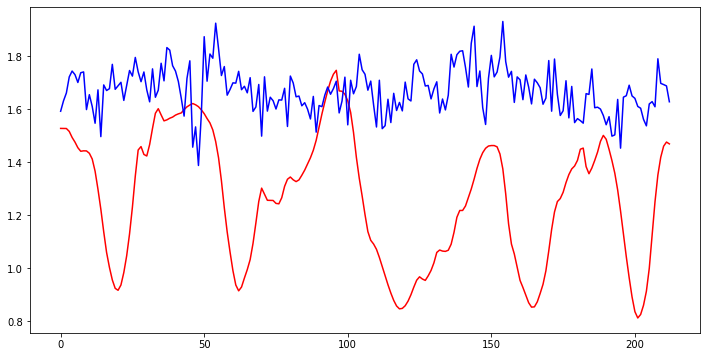

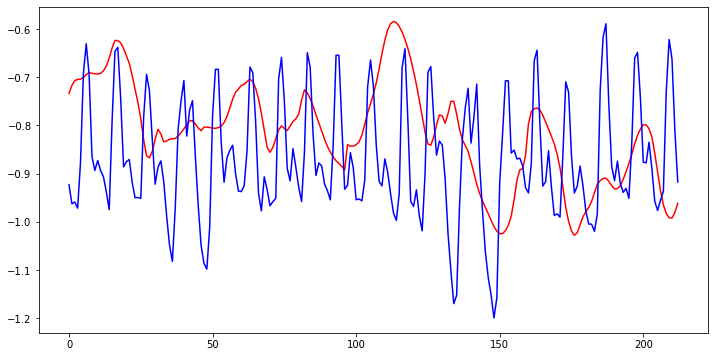

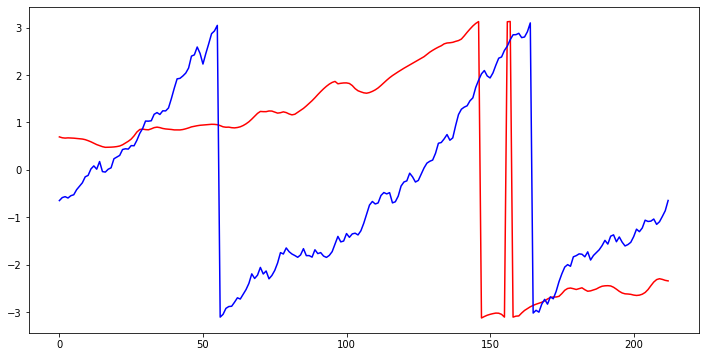

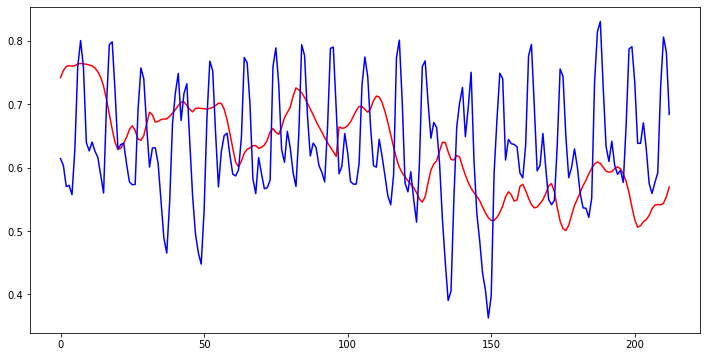

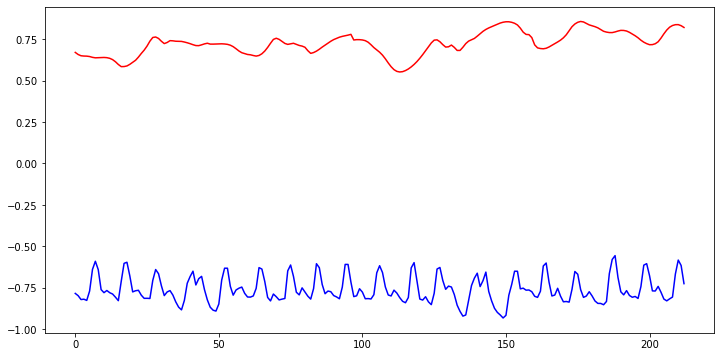

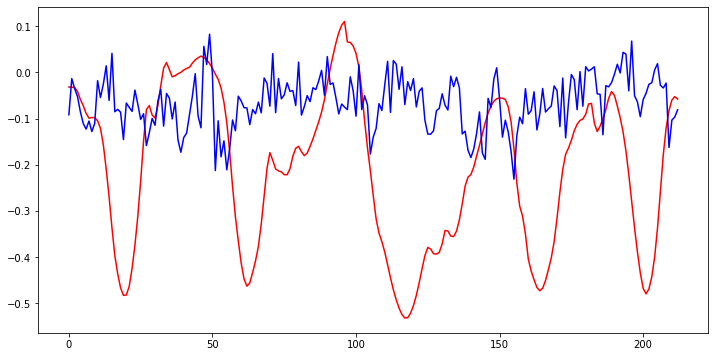

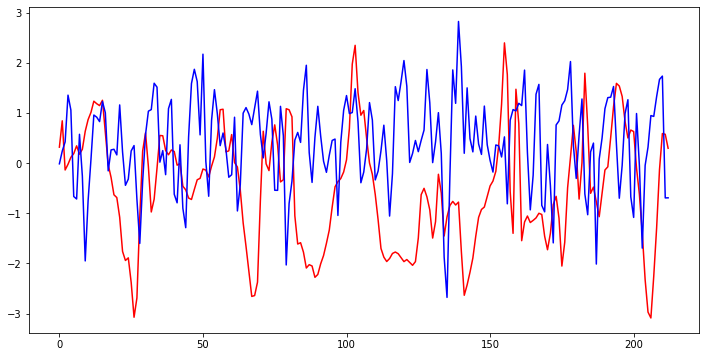

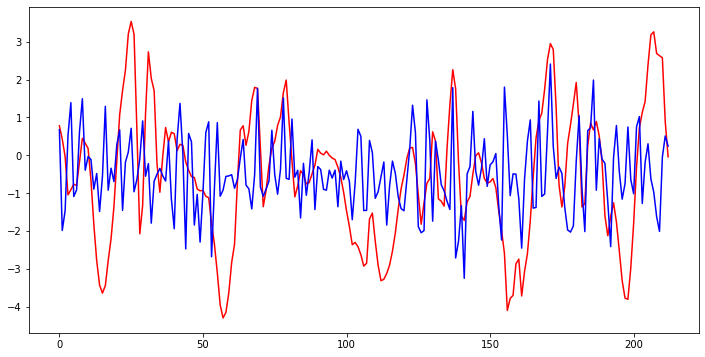

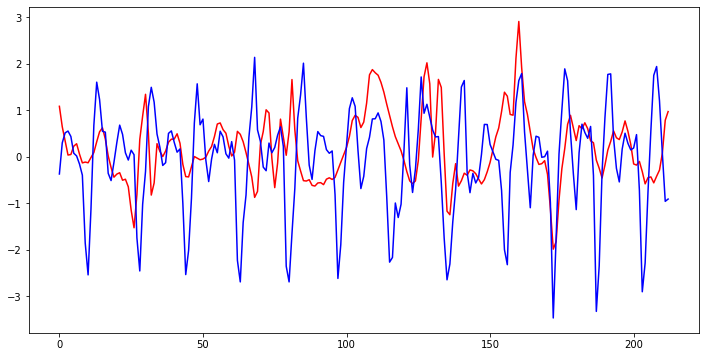

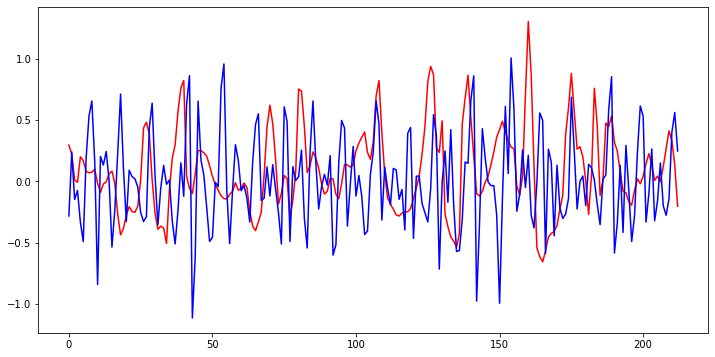

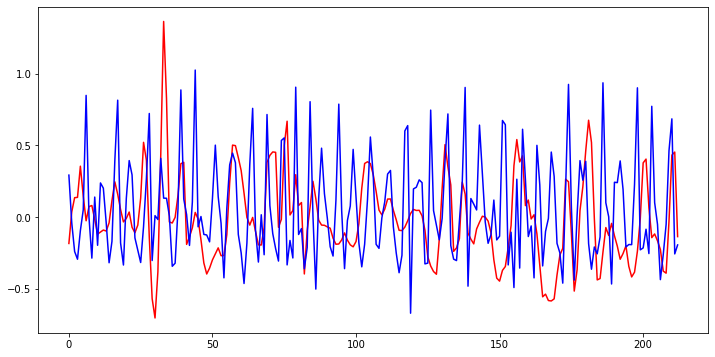

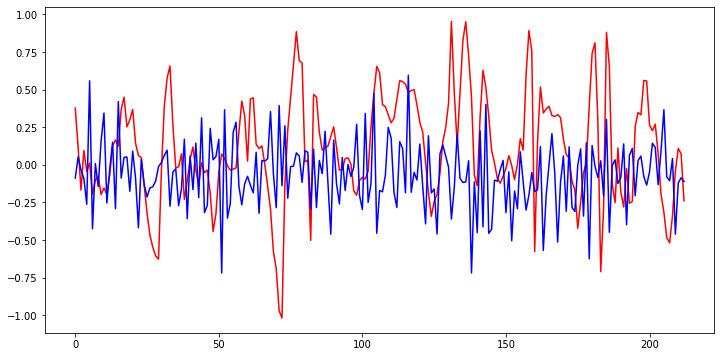

In [17]:
walking_data = df[df['activity'] == 'downstairs'].to_numpy()
real_data = test_df.to_numpy()

for idx in range(X_train.shape[1]):
    plt.figure(figsize=[12,6])
    plt.plot(walking_data[0:real_data.shape[0], idx], color='r')
    plt.plot(real_data[:, idx], color='b')